In [81]:
import numpy as np
import pandas as pd
from time import strftime
import matplotlib
import matplotlib.pyplot as plt
from math import log
%matplotlib inline
%config inlinebackend.figure_format = 'svg'
import seaborn as sns
from scipy import stats

In [82]:
# Данный анализ проводится на данных по аренде байков в г. Вашингтон. 
# Загрузим данные и познакомимся с таблицей

df = pd.read_csv('train.csv')
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


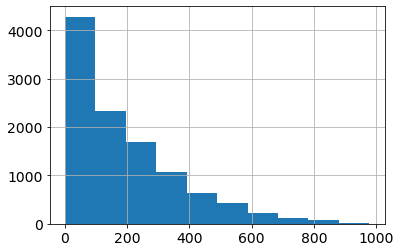

In [83]:
# Целевым признаком в данном случае является признак 'count', отражающий интенсивность распределения
# заказов: количество заказов в час. Построим гистрограмму частот :

df['count'].hist(bins = 10)
plt.tick_params(labelsize=14)

In [84]:
# В данном случае мы имеем дело с сильно вытянутым левым столбцом,
# 40 % наблюдений 'count' находится в пределах 100 заказов в час.
df.loc[df['count']<=100,'count'].count()/df['count'].count()

0.3975748668013963

In [85]:
# Среднее значение равно около 200, а мода всего 5.
f"Среднее: {df['count'].mean()}, Медиана: {df['count'].median()}, Мода: {df['count'].mode()[0]}"

'Среднее: 191.57413191254824, Медиана: 145.0, Мода: 5'

In [86]:
# Признак 'count' разделяется на два подпризнака : 'registered'  и 'casual'.
# Эти два признака отличаются между собой, как по объему, так и по структуре,
# поэтому в дальнейшем анализ будет вестись в разрезе этих признаков
f" Доли: registered- {df['registered'].sum()/df['count'].sum()}, casual- {df['casual'].sum()/df['count'].sum()}"

' Доли: registered- 0.811968586548107, casual- 0.188031413451893'

In [87]:
# Познакомимся с другими признаками
# В этой таблице отсутствуют пропуски

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
datetime      10886 non-null object
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [88]:
# Также отсутствуют видимые выбросы
df.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


In [89]:
# Выделим из признака 'datetime'  признаки 'month'  и 'hour'
df['datetime']= df.datetime.apply(pd.to_datetime)
df['hour']=df.datetime.apply(lambda x: x.hour)
df['month']=df.datetime.apply(lambda x: x.month)

In [80]:
# Построим корреляционную таблицу по признакам 'registered'  и 'casual'. 
# Поскольку распределение не является нормальным, в качестве коэффициента корреляции используем ранговый
# коэффициент Кенделла.

df.corr('kendall')[['registered','casual']].sort_values('registered',ascending = False)

,registered,casual
registered,1.000000,0.582213
count,0.919346,0.666411
casual,0.582213,1.000000
hour,0.339485,0.328520
temp,0.240250,0.413319
atemp,0.237979,0.410275
season,0.132095,0.120411
month,0.127366,0.111100
windspeed,0.090491,0.095200
workingday,0.051604,-0.165217


In [90]:
# Удалим дублирующие признаки и еще раз посмотрим на таблицу
df.drop(['datetime','atemp', 'season', 'windspeed','weather' ,'holiday','count'],axis=1,inplace = True)
df.corr('kendall').loc[['workingday', 'temp', 'humidity', 'hour',
       'month'],['registered','casual']].sort_values('registered',ascending = False)

,registered,casual
hour,0.339485,0.328520
temp,0.240250,0.413319
month,0.127366,0.111100
workingday,0.051604,-0.165217
humidity,-0.224517,-0.261280


In [12]:
# В итоге, мы имеем два целевых признака:'registered'(зарегестрированные) и  'casual' (случайные),
# и  две группы факторных признаков : климатические ('temp' - температура и 'humidity' - влажность) и 
#  факторы деловой активности ('hour'- (час) и 'workingday' - рабочий день). Что касается признака - 
# 'month' - месяц, то он несет в себе как факторы первого, так и второго рода, хотя в большой степени
# это признак климатический.
# Рассмотрим в отдельности влияние каждого признака.

In [13]:
# Создадим функцию для построения графиков

def make_plot(p, t):
    fig, ax = plt.subplots(nrows = 1, ncols = 2)
    ax1, ax2 = ax.flatten()
    fig.set_size_inches(12,3.5)
    ax1.grid(c='lightgrey')
    ax2.grid(c='lightgrey')
    ax1.tick_params(labelsize=14)
    ax2.tick_params(labelsize=14)
    if t == 'b':
        ax2.bar(df[p],df['casual'])
        ax1.bar(df[p],df['registered'])
    elif t== 's':
        ax2.scatter(df[p],df['casual'])
        ax1.scatter(df[p],df['registered'])
    ax2.set_xlabel(p, fontsize = 16, c = 'green')
    ax2.set_ylabel('casual', fontsize = 16, c = 'green')
    ax1.set_xlabel(p, fontsize = 16,c = 'green')
    ax1.set_ylabel('registered', fontsize = 16,c = 'green')



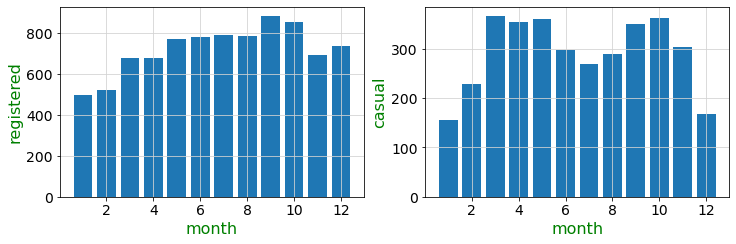

In [25]:
make_plot('month', 'b')

In [15]:
# В данном случае мы видим, что спрос и зарегестрированных, и случайных клиентов чувствителен к сезонному фактору, 
# достигая минимума в холодные месяцы и максимума в сентябре-октябре. Однако у случайных клиентов спрос более эластичен,
# достигая минимумов, помимо холодных месяцев, еще и в летние периоды, что связано, по видимумо, с сезоном отпусков.


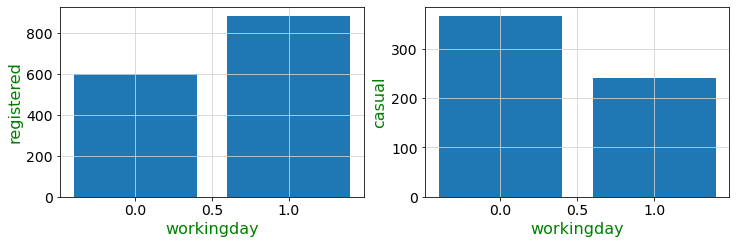

In [31]:
make_plot('workingday', 'b')

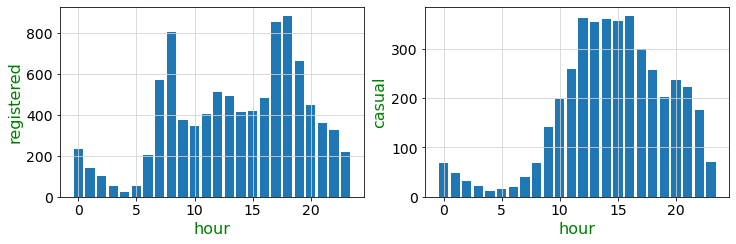

In [28]:
make_plot('hour','b')

In [18]:
# Что касается факторов деловой активности, то видим, что динамика спроса зарегестрированных и случайных клиентов
# диаметрально противоположна: у зарегестрированных выше спрос в рабочие дни, у случайных - в нерабочие.
# Если сюда наложить почасовую динамику, мы увидим, что максимумы спроса у зарегестрированных пользователей приходятся
# на часы пик: 7-8, 17-18, в то время как у случайных максимум приходится на интервал 12-16. Из этого можно сделать вывод,
# что зарегестрированные пользователи используют байки преимущественно для служебных потребностей, в то время как случайные
# используют преимущественно для отдыха и развлечений.

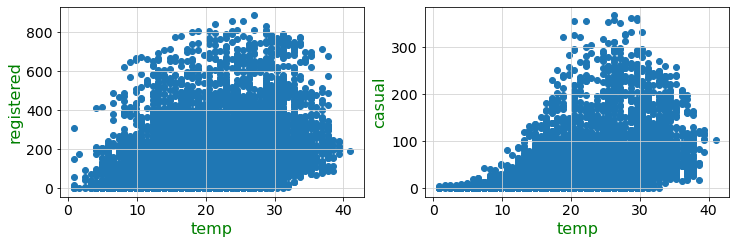

In [19]:
make_plot('temp','s')

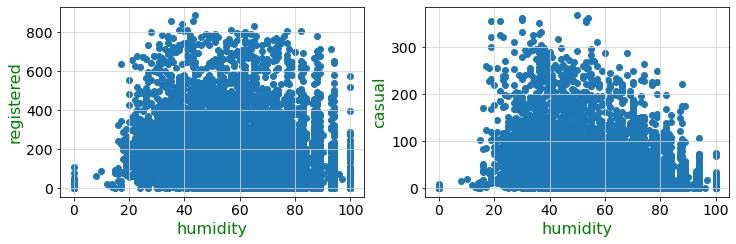

In [20]:
make_plot('humidity','s')

In [91]:
# При анализе климатических факторов бросается в глаза значительно большая эластичность спроса у случайных, чем у 
# зарегестрированных пользователей. В частности у случайных клиентов спрос резко снижается при выходе температурных 
# значений за интервал от 20 до 30 градусов, в то время как у зарегестрированных пользователей, спрос держится на достаточно
# стабильном уровне в температурном интервале от 10 до 35 градусов. Аналогичная ситуация и с влажностью. 
# Если зарегестрированные пользователи не отказываются от байков и в сырую дождливую погоду, то случайные пользователи
# предпочитают пользоваться байками в сухую погоду. Данные наблюдения потверждаются более высокими коэффициентами коррелиции
# у случайных пользователей по сравнению с зарегестрированными : 0.41 против 0.24 по температуре и 0.26 против 0.22 по
# влажности.

In [94]:
# Заключение. Подводя итог анализу, можно сделать вывод, что основной спрос на байки, около 80%, формируют
# зарегестрированные пользователи, которые используют байки преимущественно для деловых поездок. Спрос
# этих клиентов достаточно устойчив к климатическим изменениям. Около 20% составляют случайные клиенты,
# которые используют байки преимущественно для развлечения и отдыха. Спрос этих клиентов значительно более чувствителен
# к погоде. Наиболее существенными факторами являются температура и время.
# Рекомендации по увеличению спроса могут быть связаны со стимулированием спроса в периоды локальных минимумов.
# Например, можно рассмотреть акционные дисконтные программы для зарегестрированных пользователей в выходные дни.
# Это может с одной стороны, стимулировать зарегестрированных пользователей более активно пользоваться байками
# в нерабочие дни, с другой стороны регистрироваться незарегестрированных пользователей для получения скидок, что
# потенциально также может привести к увеличению спроса. В качестве еще одной меры можно было бы предложить 
# маркетинговые программы, направленные на стимулирование спроса в период летних отпусков.